In [56]:
import pandas as pd

df = pd.read_csv("user_behavior_dataset.csv")

print(df.head())
print(df.info())

   User_ID    Device_Model Operating_System  App_Usage_Time  Screen_On_Time  \
0        1  Google Pixel 5          Android             393             6.4   
1        2       OnePlus 9          Android             268             4.7   
2        3    Xiaomi Mi 11          Android             154             4.0   
3        4  Google Pixel 5          Android             239             4.8   
4        5       iPhone 12              iOS             187             4.3   

   Battery_Drain  Number_of_Apps_Installed  Data_Usage  Age  Gender  \
0           1872                        67        1122   40    Male   
1           1331                        42         944   47  Female   
2            761                        32         322   42    Male   
3           1676                        56         871   20    Male   
4           1367                        58         988   31  Female   

   User_Behavior_Class  
0                    4  
1                    3  
2                    2 

In [57]:
df["Addiction_Score"] = (              #define a new column which will be used to classify users
    df["App_Usage_Time"] +
    df["Screen_On_Time"] * 60 +
    df["Data_Usage"]
)

median_score = df["Addiction_Score"].median()  #get column mean
df["Addicted"] = df["Addiction_Score"].apply(lambda x: "Yes" if x >= median_score else "No")  #if current user's score is higher than mean, write 'heavy'. 'light' otherwise.
df.drop("Addiction_Score", axis=1, inplace=True)
print(df['Addicted'].value_counts())

Addicted
Yes    351
No     349
Name: count, dtype: int64


In [58]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=['App_Usage_Time', 'Screen_On_Time', 'Data_Usage', 'Addicted', 'Device_Model', 'Operating_System', 'Gender'], axis=1)

X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include='object').columns:
  le = LabelEncoder()
  X_encoded[col] = le.fit_transform(X_encoded[col])
  label_encoders[col] = le

y = df['Addicted'].apply(lambda x: 1 if x == 'Yes' else 0)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [60]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

GaussianNB()

In [61]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = nb_model.predict(X_train)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

y_pred = nb_model.predict(X_test)

print("Testing Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))

Training Accuracy: 0.9
Testing Accuracy: 0.8357142857142857
              precision    recall  f1-score   support

          No       0.85      0.83      0.84        72
         Yes       0.83      0.84      0.83        68

    accuracy                           0.84       140
   macro avg       0.84      0.84      0.84       140
weighted avg       0.84      0.84      0.84       140



AUC Score: 0.9562908496732025


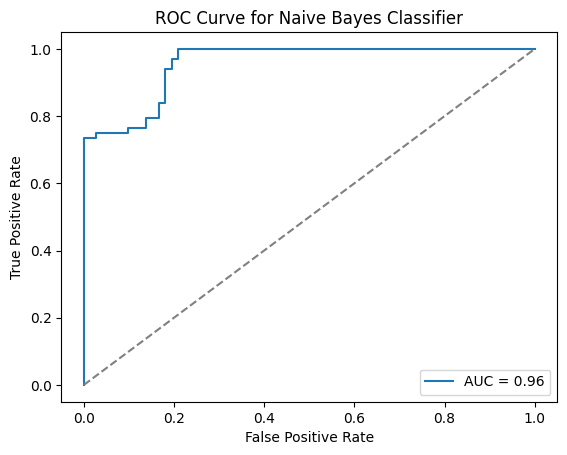

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get prediction probabilities
y_probs = nb_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
print("AUC Score:", auc)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.legend()
plt.show()


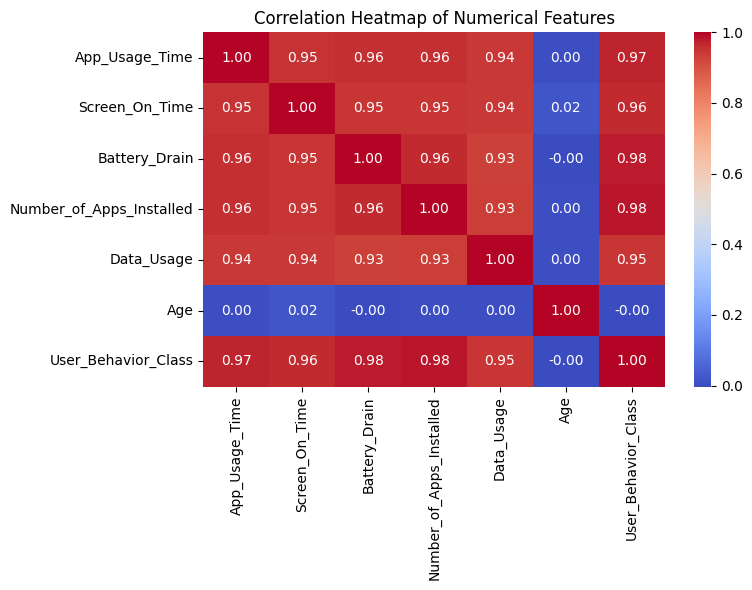

In [63]:
import seaborn as sns

# Load the dataset
df = pd.read_csv("user_behavior_dataset.csv")

# Optional: drop User_ID since it's just an identifier
numeric_features = df.select_dtypes(include='number').drop(columns=["User_ID"])

# Generate the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


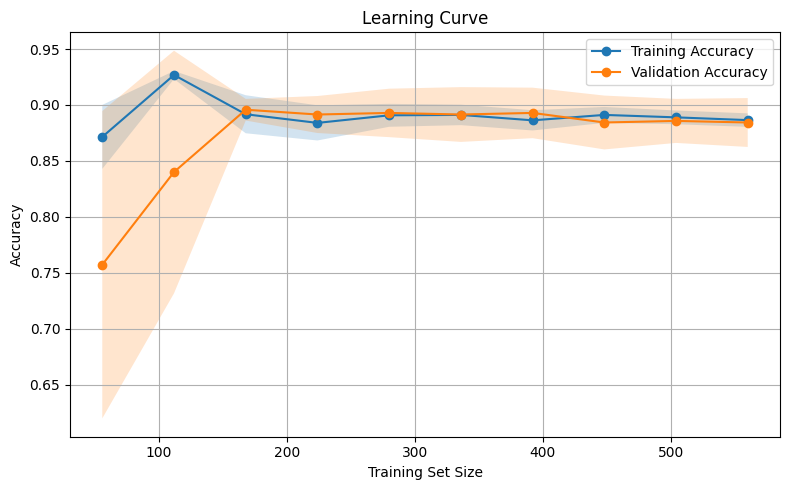

In [64]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    GaussianNB(), X, y, cv=StratifiedKFold(n_splits=5),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()